# Detect Road Lines Lines on Images and Videos

## Project Overview and Motivation
This jupyter notebook will demonstrate the concepts on how to detect road lines on images and videos.  

This is a first task to do in a self driving car application.  The task here is to use simple computer vision to build a framework to do the road line detection pipeline. 

We will use matplotlib, numpy and opencv to complete these tasks.

The pipeline include the following steps:
- Load the image and convert to the color space (RGB).  In this case we are using the worst case to do a image processing pipeline because we could use LAB or HSV color spaces that we could separate well the true colors.
- Collect edges by gradients using canny edge detector.  This part of the pipepline will aid us to do detect long gradient distribution variations.
- Detect lines using hough transforms.  With hough transforms we could match slope an intercept with respect a set of points and later match the current parameters to x,y positions in the image.
- Average the lines.  When all the hough lines are detected we could select the simple method to match the hough lines by averaging or doing simple math to connect the dots.
- Weight the image to the original.  Finally all the information is merged in one channel.

In the notebook we will guide you to complete the tutorial.

## The LaneLinesDetector Class

We will use **matplotlib** basically to plot every image and show an output.

**Numpy** to do algebraic calculations with arrays or lists

**OpenCV** will be the prefered library in our project for computer vision tasks

Finally **os** but not neccesary to join the paths and could be independent of the operating system, linux, windows or mac.

In [1]:
# Do relevant imports

import matplotlib.pyplot as plt # for graphing purposes
import numpy as np              # for array operations
import cv2                      # for the image processing pipeline
import os                       # for path arranging despite the os

In [2]:
#  Class for Road Lines

class LaneLinesDetector:
    """ A Road Line Detector Class for detecting lane lines by pure image processing
    
    Input:
    None
       
    Output:
    A marked image with the road lines.  Not a perfect algorithm but still functional ;).
    """
    
    def __init__(self):
        """ Class initializer
    
        Input:
        None
       
        Output:
        None, just pass for the class to be initialized.
        """
        pass

    def canny(self, img, ksize=5, low_thr=50, high_thr=150):
        """ An edge detector pipeline based on canny edge and blurring.
    
        Input:
        img. np.array().  The image array of a single or multiple channel.
        ksize. int.  The kernel size, the number must be odd.
        low_thr. int.  The threshold composed of the low level of sensitivity for the canny edge detector.
        hight_thr. int.  The threhold composed of the highest level of sensitivity for the canny edge detector
       
        Output:
        img. np.array().  The array composed of the image in a single channel, borders only.
        """        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)      # convert to gray
        blur = cv2.GaussianBlur(gray, (ksize, ksize), 0)  # blur some ammount to smooth borders
        canny = cv2.Canny(blur, low_thr, high_thr)        # edge detection
        return canny                                      # return the boundaries detected

    def get_roi(self, img, vertices, color=(255, 255, 255)):
        """ A simple part of the pipeline that crops an irregular regiond by its vertices.
    
        Input:
        img. np.array().  The image array of a single or multiple channel.
        vertices. np.array().  With format [(x0,y0), (x1, y1).., (xn, yn)] is the array of points to crop.
        color. tuple.  color of the region to mask, generally a white mask to "AND"it
       
        Output:
        mask. np.array().  The array composed of the image masked in a single channel array.
        """            
        mask = np.zeros_like(img)                          # create a white canvas
        cv2.fillPoly(mask, pts = [vertices], color=color)  # fill the canvas with the part to be anded
        mask = cv2.bitwise_and(img, mask)                  # make the mask
        return mask                                        # retur the mask
    
    def compute_hough(self, img, houghparams = dict([("rho" , 4), ("theta" , np.pi/180), ("threshold" , 15), 
                                                     ('min_line_lenght', 40), ('max_line_gap', 19)]),
                      color=(255,0,0), thickness=5):
        """ A simple part of the pipeline that crops an irregular regiond by its vertices.
    
        Input:
        img. np.array().  The image array of a single or multiple channel.
        vertices. np.array().  With format [(x0,y0), (x1, y1).., (xn, yn)] is the array of points to crop.
        houghparams. dict().  A dictionary composed of different houhg line detector parameters that consists of...
            rho. int. the distance resolution in pixels of the hough grid.
            theta. int. the angular resolution in radians of the hough grid.
            threshold.  int.  the minimum number of votes or intersection in hough grid cell.
            min_line_lenght. int. the minimun number of pixels making up a line.
            max_line_gap. int. maxixmum gain in pixels between connectable line segments.
        color. tuple. A tuple that consists of the color of the lines.
        thickness. int. The widht of the road lines marks.
       
        Output:
        lines. np.array().  A union of points in lines detected.
        """             
        rho = houghparams['rho']                          # resolution in pixels
        theta = houghparams['theta']                      # angular resolution in radians
        threshold = houghparams['threshold']              # minimum number of intersections
        min_line_length = houghparams['min_line_lenght']  # minimum number of pixels making up a line
        max_line_gap = houghparams['max_line_gap']        # maximum gap in pixels between connectable line segments
        
        # Run the probabilistic hough detector
        lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
        return lines                                      # return the lines detected

    def draw_lines_simple(self, img, lines, color=(255,0,0), thickness=5):
        """ Draw the lines based on simple tuple extraction.
    
        Input:
        img. np.array().  The image array of a single or multiple channel.
        lines. np.array().  A union of points in lines detected.
        color. tuple. A tuple that consists of the color of the lines.
        thickness. int. The widht of the road lines marks.
       
        Output:
        img. np.array().  The image array of a 3 channel color image.
        """        
        if np.sum(lines) == None:                         # for error handling, if no lines, return the image
            return img
        
        img = np.zeros_like(img)                          # start by making a canvas
        if len(img.shape) == 2:                           # if the image is of 1ch
            img = cv2.merge((img,img,img))                # make a 3ch image
        for line in lines:                                # for every line
            x1,y1,x2,y2 = line.reshape(4)                 # reshape the points
            cv2.line(img, (x1, y1), (x2, y2), color, thickness) # graph over the image a line
        return img                                        # return the marked image
        
    def draw_lines_average(self, img, lines, color=(255,0,0), thickness=5):
        """ Draw the lines based on simple tuple extraction.
    
        Input:
        img. np.array().  The image array of a single or multiple channel.
        lines. np.array().  A union of points in lines detected.
        color. tuple. A tuple that consists of the color of the lines.
        thickness. int. The widht of the road lines marks.
       
        Output:
        img. np.array().  The image array of a 3 channel color image.
        """
        img = np.zeros_like(img)                          # make a canvas
        if len(img.shape) == 2:                           # if is a 1ch image
            img = cv2.merge((img,img,img))                # make it a 3ch image
        lt_line, rt_line = list(), list()                 # create a list of lines
        for line in lines:                                # for each line
            x1,y1,x2,y2 = line.reshape(4)                 # get the list of points
            params = np.polyfit((x1,x2), (y1,y2), 1)      # try to make a polygon fit by coordinates
            slope, intercept = params[0], params[1]       # get the parameters of a straight line
            if slope < 0:                                 # if is the left line (slope is negative)
                lt_line.append((slope, intercept))        # append to the left line list
            else:                                         # on the other hand
                rt_line.append((slope, intercept))        # append to the right line list
        lt_params = np.average(lt_line, axis=0)           # average each parameter listed
        rt_params = np.average(rt_line, axis=0)           # average each parameter listed
        
        # exception handling and bypassing section
        try:                                              # get the slopes of left and right lines
            slope1 = lt_params[0]                        
            slope2 = rt_params[0]
        except:
            return img                                    # return the image if an exception occurs
        if abs(slope1) < 0.2 or abs(slope2) < 0.2:        # if is not a good slope return the image
            return img
        # end of exception handling and bypassing section
        
        h = img.shape[0]                                  # get the height
        lt_coords = self.get_coords(h, lt_params)         # get the left coordinates
        rt_coords = self.get_coords(h, rt_params)         # get the right coordinates
        
        p1l, p1r = lt_coords                              # get the left points
        p2l, p2r = rt_coords                              # get the right points
        cv2.line(img, p1l, p1r, color, thickness)         # draw the left line
        cv2.line(img, p2l, p2r, color, thickness)         # draw the right line
        return img                                        # return the image

    def get_coords(self, h, params):
        """ get the coordinates based on line parameters.
    
        Input:
        h. int. The height of the image (max height).
        params. tuple.  The slope and intercept parametes of a line
       
        Output:
        (x1, y1), (x2, y2). tuple.  The tuple containing the points of the corresponding line.
        """        
        slope, intercept = params                         # get slope and intercept parameters
        y1 = h                                            # get the left line max height
        y2 = int((19/32)*h)                               # get the other point by a croped height
        x1 = int((y1 - intercept)/slope)                  # calculate the left position of the line
        x2 = int((y2 - intercept)/slope)                  # calculate the right position of the line
        return (x1, y1), (x2, y2)                         # return the point coordinates

    # lines processing pipeline
    def process(self, img, params, vertices, avg=True):
        """ Complete image process pipeline.
    
        Input:
        img. np.array().  The image as an array
        params.  dict().  the canny edge and hough parametes, color and threshold.  
                          See canny and compute_hough functions.
        vertices. np.array().  An array of the vertices.
        avg.  bool.  A boolean value for the image pipeline to process.
       
        Output:
        img.  np.array(). The final image of the pipeline
        """           
        
        # dictionary parameters, see respective functions canny, get_roi, compute_hough, get_lines_* for each parameters
        ksize = params['ksize']
        low_thr = params['low_thr']
        high_thr = params['high_thr']
        rho = params['rho']
        theta = params['theta']
        threshold=params['threshold']
        min_line_lenght=params['min_line_lenght']
        max_line_gap=params['max_line_gap']
        color=params['color']
        thickness=params['thickness']
    
        # complete hough dictionary
        houghparams=dict({'rho':rho, 'theta':theta, 'threshold':threshold,
                          'min_line_lenght':min_line_lenght, 'max_line_gap':max_line_gap
                         })
        
        # Do a canny edge detection
        canny = self.canny(img, ksize=ksize, low_thr=low_thr, high_thr=high_thr)
        # mark the roi
        roi = self.get_roi(canny, vertices)
        # compute lines by probabilistic hough
        lines = self.compute_hough(roi, houghparams=houghparams) 
        # process line average or simple lines
        if avg:
            marked_lines = self.draw_lines_average(roi, lines, color=color, thickness=thickness) # by average
        else: 
            marked_lines = self.draw_lines_simple(roi, lines, color=color, thickness=thickness)  # by simple marking
        img = cv2.addWeighted(img[:,:,::-1], 0.8, marked_lines[:,:,::-1], 1, 0)                  # compute weighted images
        return img                                                                               # return the image

## Image Processing Pipeline Tests

We now will use the image processing pipeline for making tests over an image.

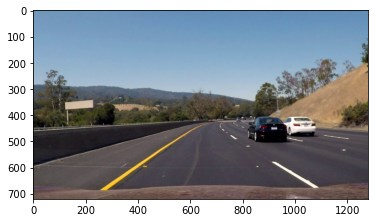

In [3]:
# Graph a simple image

imgpath = os.path.join('test_images', 'challenge.jpg') # Use the image path 
img = cv2.imread(imgpath)                              # load the image

ld = LaneLinesDetector()                               # Instantiate the class
plt.imshow(img[:,:,::-1])                              # plot the image
plt.show()                                             # if not shown this command will help

We now will do a canny edge detection.  This axis *ticks* labeling will help us to get better anchor points for the polygon box

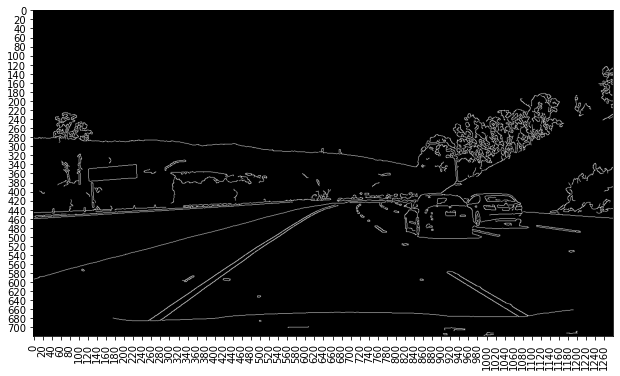

In [4]:
canny = ld.canny(img.copy(), ksize=5, low_thr=50, high_thr=150)  # canny edge detection over (50, 150) threshold
plt.figure(figsize=(12,6))                                       # oversize the image for better visualization
plt.xticks(np.arange(0, canny.shape[1], step=20), rotation=90)   # use the xticks to see the division
plt.yticks(np.arange(0, canny.shape[0], step=20), rotation=0)    # use the yticks to see the division
plt.imshow(canny, cmap='gray')                                   # plot using the gray map
plt.show()                                                       # use this if it doesn't shows up

The region of interest is a part of the image where we are focused only of the image processing, if we get the region of interest we improve the computation time and also helps the algorithm to go faster.

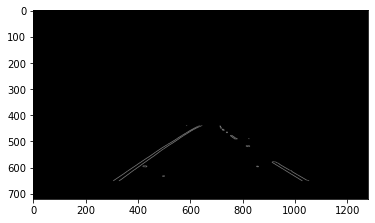

In [5]:
# test the roi

#horizon = 310
#vertices = np.array([[85, ysize], [474, horizon], [900, ysize]])
#vertices = np.array([[100, ysize], [350, horizon], [550, horizon], [875, ysize]])
#horizon = 400
#vertices = np.array([[240, ysize-60], [600, horizon], [750, horizon], [1050, ysize-60]])

ysize=canny.shape[0]                                                       # get the size of the image
h = 440                                                                    # height of the image
offset = 650                                                               # offset over the height of the image, see the line of the car
vertices = np.array([[265, offset], [585, h], [740, h], [1100, offset]])   # vertices corresponding of the image restrictions

roi = ld.get_roi(canny, vertices)                                          # compute the roi polygon
plt.imshow(roi, cmap='gray')                                               # show the image in grayscale mode
plt.show()                                                                 # show if it still doesn't shows

Now we will compute the hough paramters.  The probabilistic hough will give us the estimation of the lines that could be found on the image based on the probabilistic computation.

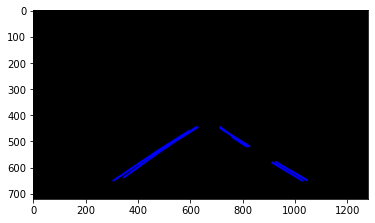

In [6]:
houghparams = dict([("rho" , 1), ("theta" , np.pi/180), ("threshold" , 15),  # hough dictionary 
                   ('min_line_lenght', 50), ('max_line_gap', 60)])

lines = ld.compute_hough(roi, houghparams=houghparams)                       # get the lines
marked_lines = ld.draw_lines_simple(roi, lines)                            # mark the lines as simple as possible on the image
plt.imshow(marked_lines[:,:,::-1])                                           # show the image of the marked lines
plt.show()                                                                   # use this if nothing happens

We will repeat the same steps as above to see the results based on averagint the lines by using a polynomial fit

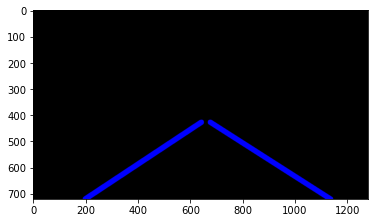

In [7]:
lines = ld.compute_hough(roi)                                   # compute probabilistic hough to find the lines
marked_lines = ld.draw_lines_average(roi, lines, thickness=20)  # mark the lines over the canvas
plt.imshow(marked_lines[:,:,::-1])                                # show the image
plt.show()                                                        # use this line below if something is not show

Finally we weight the image over the previous canvas to get the line

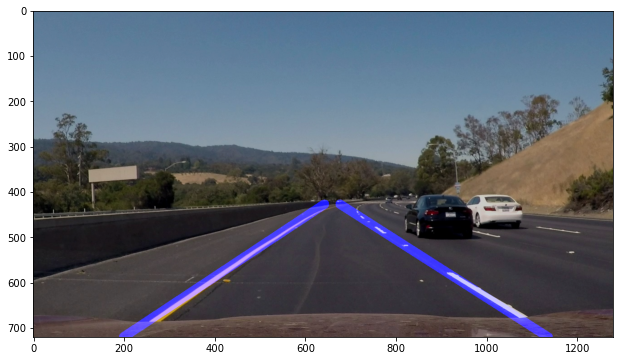

In [8]:
lane_detection = cv2.addWeighted(img[:,:,::-1], 0.8, marked_lines[:,:,::-1], 1, 0)  # add the marked lines to the original image
plt.figure(figsize=(12,6))                                                          # change the figure size
plt.imshow(lane_detection)                                                          # show the detected lane
plt.show()                                                                          # show the plot if above doesnt works

## Testing the pipeline by hand

We now will make a program based on the parts of the class to test the pipeline

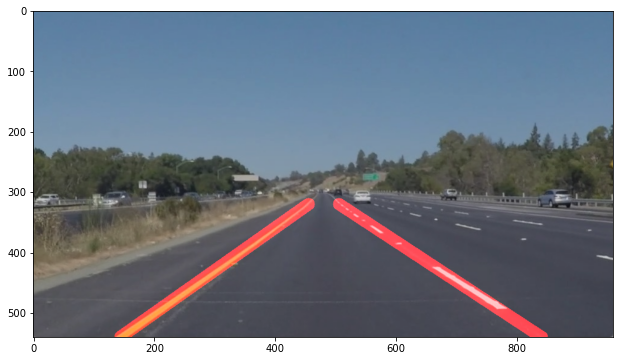

In [9]:
imgpath = os.path.join('test_images', 'solidYellowLeft.jpg')      # load the path of the image
#imgpath = os.path.join('test_images', 'solidWhiteRight.jpg')
#imgpath = os.path.join('test_images', 'challenge.jpg')
img = cv2.imread(imgpath, cv2.IMREAD_COLOR)                              # load the image

# get initial parameters of vertices and the key & vals pairs
ysize=img.shape[0]                                                # size of the image
horizon = 300                                                     # region to crop
vertices = np.array([[100, ysize], [500, horizon], [900, ysize]]) # the vertices of the region of interest

# key value pairs for the algorithms used
key_vals_pair = {'ksize': 5, 'low_thr': 50, 'high_thr': 150, # canny edge detector parameters
                 'rho': 4, 'theta': np.pi/180, 'threshold': 15, 'min_line_lenght': 40, 'max_line_gap': 19, # hough lines parameters
                 'color':(0, 0, 255), 'thickness': 20}            # drawing paramters

params = dict(key_vals_pair)                                      # match the key and values

ld = LaneLinesDetector()                                          # process the road lanes
frame = ld.process(img, params, vertices, avg=True)              # load, convert to gray, blur, do canny, get the roi, draw lines
plt.figure(figsize=(12,6))                                        # display figure size
plt.imshow(frame)                                                 # get the image 
plt.show()                                                        # show it

# OpenCV Function - Applicatiom

We will create a python file for the OpenCV function, now we will not only capture but also test our simualted example.

In [10]:
#name = 'challenge.mp4'                                         # Video to read
#name = 'solidWhiteRight.mp4'
name = 'solidYellowLeft.mp4'
video_input_path = os.path.join('test_videos', name)           # input video path
video_output_path = os.path.join('test_videos_output', name)   # output video path
cap = cv2.VideoCapture(video_input_path)                       # open the video
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))                    # get the widht and height as integers, copy the same...
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))                     
fps = int(cap.get(cv2.CAP_PROP_FPS))                           # ... fps to the video writer
print((h,w))

out = cv2.VideoWriter(video_output_path,cv2.VideoWriter_fourcc('M','J','P','G'), fps, (w,h)) # open an output video operation

# get initial parameters
ysize=h
#SolidWhiteRight
#horizon = 310
#vertices = np.array([[85, ysize], [475, horizon], [900, ysize]])
#SolidYellowLeft
horizon = 300
vertices = np.array([[100, ysize], [500, horizon], [900, ysize]])
#General Solution
#horizon = 250
#vertices = np.array([[93, ysize], [487, horizon], [900, ysize]])
#Challenge
#horizon = 430
#vertices = np.array([[240, ysize-60], [600, horizon], [750, horizon], [1050, ysize-60]])

# Solid white right: 5, 50, 150, 4, np.pi/180, 15, 40, 19
# Solid white left: 5, 50, 150, 1, np.pi/180, 15, 60, 30
# Challenge: 5, 50, 255, 1, np.pi/180, 15, 60, 30
key_vals_pair = {'ksize': 5, 'low_thr': 50, 'high_thr': 150,                                                # canny edge detector parameters
                 'rho': 1, 'theta': np.pi/180, 'threshold': 15, 'min_line_lenght': 60, 'max_line_gap': 30,  # hough lines parameters
                 'color':(0, 0, 255), 'thickness': 20}                                                      # drawing paramters
params = dict(key_vals_pair)                                   # get the params
ld = LaneLinesDetector()                                       # load the instance

(540, 960)


Finally here we will use the process pipeline in an opencv application.

In [11]:
while(cap.isOpened()):                                         # Read until video is completed
    ret, frame = cap.read()                                    # capture frame by frame
    if ret == True:                                            # if there is image returned
        frame = ld.process(frame, params, vertices, avg=True)  # get the processed frame
        out.write(frame[:,:,::-1])                             # write the current output
    else:                                                      # Break the loop
        break                                                  
cap.release()                                                  # release the capture instance
out.release()                                                  # release the writting instance 